In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [192]:
%matplotlib inline

In [193]:
#data_url = 'http://www.ndbc.noaa.gov/data/5day2/46022_5day.txt'
data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46022.txt'

# Set the number of hours to report.
LAST_HOURS = 24
buoy22_df = pd.read_csv(data_url, header=0, skiprows=[1], nrows=LAST_HOURS, sep='\s+', na_values=['MM', -99])
buoy22_df.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
0,2016,11,2,12,50,130,6.0,7.0,1.9,19,8.1,285,1018.7,12.3,13.7,10.5,NaN,-1.5,NaN
1,2016,11,2,11,50,140,5.0,6.0,2.2,19,8.4,337,1019.2,12.6,13.7,10.2,NaN,-0.9,NaN
2,2016,11,2,10,50,130,5.0,6.0,2.2,19,8.1,255,1019.7,12.8,13.7,10.6,NaN,-0.5,NaN
3,2016,11,2,9,50,140,4.0,5.0,2.1,21,8.2,263,1020.2,13.1,13.7,10.3,NaN,0.0,NaN
4,2016,11,2,8,50,130,5.0,6.0,2.2,21,7.7,280,1020.1,13.1,13.8,10.5,NaN,0.0,NaN


In [194]:
# Improve column names for use with datetime.
MWD_df = buoy22_df[['#YY', 'MM', 'DD', 'hh', 'mm', 'WVHT', 'DPD', 'MWD']]
MWD_df.columns = ['year', 'month', 'day', 'hour', 'minute', 'WVHT', 'DPD', 'MWD']
MWD_df.head()

,year,month,day,hour,minute,WVHT,DPD,MWD
0,2016,11,2,12,50,1.9,19,285
1,2016,11,2,11,50,2.2,19,337
2,2016,11,2,10,50,2.2,19,255
3,2016,11,2,9,50,2.1,21,263
4,2016,11,2,8,50,2.2,21,280


In [195]:
# Convert times to PST
ts = pd.to_datetime(MWD_df[['year', 'month', 'day', 'hour', 'minute']], utc=True)
last_hour = ts[0] - pd.DateOffset(hours=7)
first_hour = last_hour - pd.DateOffset(hours=LAST_HOURS)
tlt_str = 'Observations from ' + str(last_hour) + ' to ' + str(first_hour)
[ts.head(), tlt_str]

[0   2016-11-02 12:50:00
 1   2016-11-02 11:50:00
 2   2016-11-02 10:50:00
 3   2016-11-02 09:50:00
 4   2016-11-02 08:50:00
 dtype: datetime64[ns],
 'Observations from 2016-11-02 05:50:00 to 2016-11-01 05:50:00']

In [196]:
# Get pertinent information from buoy22_df and convert meters to feet.
# Change time order to oldest on top.
MWD_df = buoy22_df[['DPD', 'MWD']]
MWD_df.index = ts
feet = np.around(buoy22_df.loc[:,'WVHT'] * 3.4, decimals=1).values
MWD_df.insert(0, 'WVHT', feet)

MWD_df = MWD_df.sort_index(ascending=True, axis=0)
MWD_df = MWD_df.reset_index()
my_cols = ['data']
MWD_df.columns = ['date', 'WVHT', 'DPD', 'MWD']
MWD_df

,date,WVHT,DPD,MWD
0,2016-11-01 13:50:00,10.5,13,287
1,2016-11-01 14:50:00,8.8,12,268
2,2016-11-01 15:50:00,9.2,12,260
3,2016-11-01 16:50:00,10.9,13,271
4,2016-11-01 17:50:00,8.5,13,276
5,2016-11-01 18:50:00,9.9,12,287
6,2016-11-01 19:50:00,10.5,11,292
7,2016-11-01 20:50:00,10.9,12,295
8,2016-11-01 21:50:00,9.9,12,297
9,2016-11-01 22:50:00,9.5,13,296


In [197]:
MWD_df.describe()

,WVHT,DPD,MWD
count,24.000000,24.000000,24.000000
mean,8.504167,13.666667,287.041667
std,1.388925,3.318809,17.281503
min,6.500000,10.000000,255.000000
25%,7.500000,12.000000,279.000000
50%,8.200000,12.000000,287.000000
75%,9.600000,13.000000,296.250000
max,10.900000,21.000000,337.000000


In [198]:
# Get data for plotting
# Convert swell direction from degrees to radians
theta = np.deg2rad(MWD_df[['MWD']])
period = MWD_df[['DPD']]

# Times are indexed with ints starting at 2 so that MWD can be detected.
r = np.arange(len(theta) + 1,  1, -1)

# Get info for title string
# Max and min hights will be reported in feet
height_min = MWD_df[['WVHT']].min().values
height_max = MWD_df[['WVHT']].max().values
hts_str =  str(height_min) + '\' to ' + str(height_max) + '\''

# Get most current time reported and convert it from 'UTC' to 'PDT'
date_str = str(MWD_df.date.max() - pd.DateOffset(hours=7))
tlt_str = 'Buoy 22 Last 24 Hours ' + '\n' + date_str + '\n Hts ' + hts_str

# Scale point sizes based on max and min wave height
SMALL_PNT_SZ = 20
LARGE_PNT_SZ = 200
diff = LARGE_PNT_SZ - SMALL_PNT_SZ
m = np.divide(diff, height_max - height_min)
b = (SMALL_PNT_SZ * height_max - LARGE_PNT_SZ * height_min) / (height_max - height_min)

pnt_sz = m*MWD_df[['WVHT']] + b

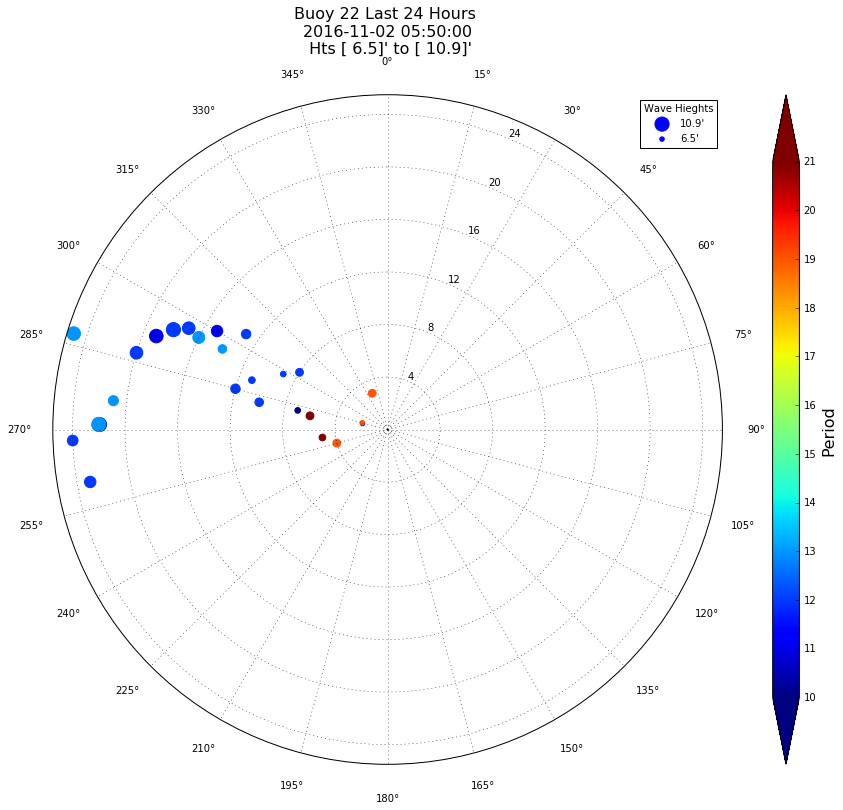

In [199]:
my_plot = plt.rcParams['figure.figsize'] =[18, 12]

ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
theta_tics = np.arange(0, 360, 15)
ax.set_thetagrids(theta_tics)
ax.set_rlim([0, 25.5])
r_tics = np.arange(4, 28, 4)
ax.set_rgrids(r_tics)
ax.grid(True)

big_idx = pnt_sz.idxmax()
small_idx = pnt_sz.idxmin()

big_str = str(float(MWD_df.iloc[big_idx]['WVHT'])) + "'"
small_str = str(float(MWD_df.iloc[small_idx]['WVHT'])) + "'"

big = ax.scatter(theta.iloc[big_idx], r[int(big_idx)], s=pnt_sz.iloc[big_idx], edgecolors='face')
small = ax.scatter(theta.iloc[small_idx], r[int(small_idx)], s=pnt_sz.iloc[small_idx], edgecolors='face')

p = ax.scatter(theta, r, s=pnt_sz, c=period, edgecolors='face')
cbar = plt.colorbar(p, extend='both', extendfrac=0.125)
cbar.set_label('Period', fontsize=16)
cbar.set_ticks(np.arange(period.min(), period.max() + 1))

ax.set_title(tlt_str, va='bottom', fontsize=16)

#Legend Stuff
# Plot legend.
lgnd = plt.legend([big_str, small_str], loc="upper right", scatterpoints=1, fontsize=10, title='Wave Hieghts')
#lgnd.legendHandles[0]._sizes = [10]
#lgnd.legendHandles[1]._sizes = [40]

plt.show(ax)